In [1]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns',100)
pd.set_option('display.max_columns',100)
pd.set_option('expand_frame_repr',False)
#import calendar

In [2]:
# Reading the input file

import os
cwd = os.getcwd()
train = cwd + "\\Source\\train.csv"
train = pd.read_csv(train)

test = cwd + "\\Source\\test.csv"
test = pd.read_csv(test)

In [19]:
# print(train[train['Employment.Type'].notnull()]['loan_default'].value_counts() / len(train[train['Employment.Type'].notnull()]))
# print(train[train['Employment.Type'].isnull()]['loan_default'].value_counts() / len(train[train['Employment.Type'].isnull()]))
# print(train[train['Employment.Type']=='Self employed']['loan_default'].value_counts() / len(train[train['Employment.Type']=='Self employed']))
# print(train[train['Employment.Type']=='Salaried']['loan_default'].value_counts() / len(train[train['Employment.Type']=='Salaried']))

# # Though there are not much differences between the default distribution, it appears as if the Salaried people are more 
# # likely to pay loan in item when compared to Self Employed

In [3]:
# Converting the date formats

train['Date.of.Birth'] = pd.to_datetime(train['Date.of.Birth'], dayfirst=True)
train['DisbursalDate'] = pd.to_datetime(train['DisbursalDate'], dayfirst=True)

test['Date.of.Birth'] = pd.to_datetime(test['Date.of.Birth'], dayfirst=True)
test['DisbursalDate'] = pd.to_datetime(test['DisbursalDate'], dayfirst=True)

In [46]:
# Feature Engineering

# Creating the age of loan applicant at the time of disbursal
train['Age_when_applying'] = (train['DisbursalDate'] - train['Date.of.Birth']).dt.days / 365
test['Age_when_applying'] = (train['DisbursalDate'] - test['Date.of.Birth']).dt.days / 365

# Creating the avg acct age and cred hist age in months
train['avg_acct_age_mnth'] = ((train['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype('int64')*12) + train['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype('int64'))
train['avg_credit_hist_mnth'] = ((train['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype('int64')*12) + train['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype('int64'))

test['avg_acct_age_mnth'] = ((test['AVERAGE.ACCT.AGE'].str.extract('(\d+)yrs').astype('int64')*12) + test['AVERAGE.ACCT.AGE'].str.extract('(\d+)mon').astype('int64'))
test['avg_credit_hist_mnth'] = ((test['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)yrs').astype('int64')*12) + test['CREDIT.HISTORY.LENGTH'].str.extract('(\d+)mon').astype('int64'))

# Creating a Overdue Percentage for Primary and Seconardy Accounts

train['prim_overdue_acct_pct'] = (train['PRI.OVERDUE.ACCTS'] / train['PRI.NO.OF.ACCTS']).fillna(0)
train['sec_overdue_acct_pct'] = (train['SEC.OVERDUE.ACCTS'] / train['SEC.NO.OF.ACCTS']).fillna(0)

test['prim_overdue_acct_pct'] = (test['PRI.OVERDUE.ACCTS'] / test['PRI.NO.OF.ACCTS']).fillna(0)
test['sec_overdue_acct_pct'] = (test['SEC.OVERDUE.ACCTS'] / test['SEC.NO.OF.ACCTS']).fillna(0)

# Creating loan to asset ratio
train['asset_to_loan_pct'] =  train['asset_cost'] / train['disbursed_amount']
test['asset_to_loan_pct'] =  test['asset_cost'] / test['disbursed_amount']

# Imputing zero values of CNS Score (Test data also imputed with train mean)
train.loc[train['PERFORM_CNS.SCORE']==0, 'PERFORM_CNS.SCORE'] = train['PERFORM_CNS.SCORE'][train['PERFORM_CNS.SCORE'] != 0].mean()
test.loc[test['PERFORM_CNS.SCORE']==0, 'PERFORM_CNS.SCORE'] = train['PERFORM_CNS.SCORE'][train['PERFORM_CNS.SCORE'] != 0].mean()

In [54]:
# Selecting columns for predictors:

predictors = ['disbursed_amount', 'asset_cost', 'ltv','MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT',
       'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'avg_acct_age_mnth', 'avg_credit_hist_mnth',
       'Age_when_applying', 'prim_overdue_acct_pct', 'sec_overdue_acct_pct', 'asset_to_loan_pct']

target = 'loan_default'
x = train[predictors]
y = train[target]
test_data = test[predictors]

In [55]:
# Standardizing the data to perform naive bayes

from sklearn.preprocessing import QuantileTransformer

transform_data = QuantileTransformer(output_distribution='normal')
col_names = x.columns

x = transform_data.fit_transform(x)
x = pd.DataFrame(data=x, columns=col_names)

test_data = transform_data.fit_transform(test_data)
test_data = pd.DataFrame(data=test_data, columns=col_names)

In [78]:
# Train and Validation Split

from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(x,y, stratify=y, random_state=1, test_size=0.25)

In [79]:
# Running a Naive Bayes Model

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

# Training the model

model.fit(x_train, y_train)
train_predictions = model.predict(x_train)
predictions = model.predict(x_validation)

In [ ]:
# # Converting to lgbm dataset

# import lightgbm as lgb

# x_train = lgb.Dataset(x_train, free_raw_data=False)
# x_validation = lgb.Dataset(x_validation, free_raw_data=False)

In [75]:
# # Running LGBM

# # Setting Parameters:

# param = {
#         'num_leaves': 4,
#         'objective': 'binary',
#         'metric': 'auc',
#         'early_stopping_rounds':10,
#        }

# num_round=10
# model = lgb.train(param, x_train, num_round, valid_sets=[x_validation])

[1]	valid_0's auc: 1
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 1
[3]	valid_0's auc: 1
[4]	valid_0's auc: 1
[5]	valid_0's auc: 1
[6]	valid_0's auc: 1
[7]	valid_0's auc: 1
[8]	valid_0's auc: 1
[9]	valid_0's auc: 1
[10]	valid_0's auc: 1
Did not meet early stopping. Best iteration is:
[1]	valid_0's auc: 1


C:\Users\sivac\Miniconda3\envs\MyNewPythonEnvironment\lib\site-packages\lightgbm\engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [80]:
# Confusion Matrix and Report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Confusion Matrix Comparison
print("Confustion Matrix for Training Data")
print(confusion_matrix(y_train, train_predictions))
print("Confustion Matrix for Test Data")
print(confusion_matrix(y_validation, predictions))

# Classification Report Comparison
print("Classification Report for Training Data")
print(classification_report(y_train, train_predictions))
print("Classification Report for Test Data")
print(classification_report(y_validation, predictions))

Confustion Matrix for Training Data
[[101667  35240]
 [ 23662  14296]]
Confustion Matrix for Test Data
[[33976 11660]
 [ 7854  4799]]
Classification Report for Training Data
             precision    recall  f1-score   support

          0       0.81      0.74      0.78    136907
          1       0.29      0.38      0.33     37958

avg / total       0.70      0.66      0.68    174865

Classification Report for Test Data
             precision    recall  f1-score   support

          0       0.81      0.74      0.78     45636
          1       0.29      0.38      0.33     12653

avg / total       0.70      0.67      0.68     58289



AUROC Plot: 0.6029


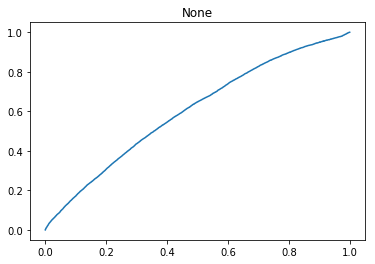

In [81]:
# AUC ROC CURVE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

predictions = model.predict_proba(x_validation)[:,1]
roc_auc_score(y_validation, predictions, average='weighted')

fpr, tpr, threshold = roc_curve(y_validation, predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("AUROC Plot:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

In [83]:
# Applying Model for Test Data

predictions = model.predict_proba(test_data)[:,1]
id_code = test['UniqueID']

output = pd.DataFrame({'UniqueID': id_code, 'loan_default':predictions})


In [87]:
output.to_csv(cwd + "\\Output\\Submission 1 - QT NB NUMERIC COLS 0.60 AUC.csv", index=False)